<img src="OC.png" width="50" height="50" align="left">    

***

<center> <font size="6"> <span style='color:Blue'> P6: Classifiez automatiquement des biens de consommation </span></font> </center>  

***

<font size="3"> <span style="font-size: 1.5em" > **Partie 1 - 1/3: Etude de faisabilité via les données textuelles** </span> </font>  

**Contexte**  
**Place de marché** est une entreprise qui propose souhaite lancer une marketplace e-commerce.
<img src="PlaceDeMarche.png" width="400" height="200">
**Mission**   
* **Partie 1:**  
Réaliser une première **étude de faisabilité** de regroupement des produits de même catégorie via les descriptions ;
    * **1. textuelle** 
    * **2. image**  
    * **3. textuelle et image**
de ces produits.
* **Partie 2:**  
Réaliser une **classification supervisée** à partir des images;
    * **1. avec data augmentation**  
    * **2. avec des techniques recentes**

Dans ce notebook partie, nous analyserons le jeu de données en réalisant :
* Un prétraitement des données **texte**;
* Une extraction de features ;
* Une réduction en 2 dimensions, afin de projeter les produits sur un graphique 2D, sous la forme de points dont la couleur correspondra à la catégorie réelle ;
* Une analyse du graphique afin d’en déduire ou pas, à l’aide des descriptions, la faisabilité de regrouper automatiquement des produits de même catégorie ;
* Une réalisation d’une mesure pour confirmer ton analyse visuelle, en calculant la similarité entre les catégories réelles et les catégories issues d’une segmentation en clusters.

# Importation des données et des librairies Python pour DS

In [2]:
%load_ext pycodestyle_magic
%flake8_on 

In [1]:
# ------------------------------------------
# projet : données des produits de Place de marché
# Auteur : Rim BAHROUN
# Date: Fevrier 2023
# OpenClassrooms
# -------------------------------------------
# importation des librairies Python pour DS
# -------------------------------------------
import os
import csv

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import time
from sklearn import cluster, metrics
from sklearn import manifold

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

C:\Users\rimla\AppData\Roaming\Python\Python39\site-packages\transformers\generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


In [2]:
chemin = "./data/source/"
os.listdir(chemin)

['flipkart_com-ecommerce_sample_1050.csv']

In [3]:
# importation des données
place_marche = pd.read_csv(chemin + 'flipkart_com-ecommerce_sample_1050.csv')
data = place_marche.copy()

# Fonctions utiles

In [12]:
def preprocess_text_lem_stem(doc,
                    rejoin=True,
                    min_len_word=3,
                    force_is_alpha=True):
    """ preprocess_text est une fonction qui fait le prétraitement
    d'un document doc passer en paramètre. Elle retourne un text en
    minuscule sans les chiffres ni les stop-words avec lem et stem.
    """
    # lower
    doc = doc.lower().strip()

    # tokenize
    tokenizer = RegexpTokenizer(r'\w+|\$[\d\.]+|\S+')
    raw_tokens_list = tokenizer.tokenize(doc)

    # classics stopwords
    stop_words = set(stopwords.words('english'))
    cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]

    # no more len words
    more_than_N = [w for w in cleaned_tokens_list if len(w) >= min_len_word]

    # only alpha chars
    if force_is_alpha:
        alpha_tokens = [w for w in more_than_N if w.isalpha()]
    else:
        alpha_tokens = cleaned_tokens_list

    # lemm
    trans = WordNetLemmatizer()
    lemm_text = [trans.lemmatize(i) for i in alpha_tokens]
    # stem
    trans = PorterStemmer()
    stem_text = [trans.stem(i) for i in lemm_text]

    final = stem_text
    # manage return type
    if rejoin:
        return " ".join(final)

    return final

In [12]:
def preprocess_text(doc,
                    rejoin=True,
                    min_len_word=3,
                    force_is_alpha=True):
    """ preprocess_text est une fonction qui fait le prétraitement
    d'un document doc passer en paramètre. Elle retourne un text en
    minuscule sans les chiffres ni les stop-words avec lem et stem.
    """
    # lower
    doc = doc.lower().strip()

    # tokenize
    tokenizer = RegexpTokenizer(r'\w+|\$[\d\.]+|\S+')
    raw_tokens_list = tokenizer.tokenize(doc)

    # classics stopwords
    stop_words = set(stopwords.words('english'))
    cleaned_tokens_list = [w for w in raw_tokens_list if w not in stop_words]

    # no more len words
    more_than_N = [w for w in cleaned_tokens_list if len(w) >= min_len_word]

    # only alpha chars
    if force_is_alpha:
        alpha_tokens = [w for w in more_than_N if w.isalpha()]
    else:
        alpha_tokens = cleaned_tokens_list

    # in english
    eng_words = [i.lower() for i in words.words()]
    engl_text = [i for i in alpha_tokens if i in eng_words]

    final = engl_text
    # manage return type
    if rejoin:
        return " ".join(final)

    return final

In [2]:
def ARI_fct(features, y_cat_num):
    """
    Calcul Tsne, détermination des clusters et
    calcul ARI entre vrais catégorie et n° de clusters
    """
    features_std = StandardScaler().fit_transform(features)
    print("Dimensions dataset avant réduction PCA : ", features_std.shape)
    pca = PCA(n_components=0.99)
    feat_pca= pca.fit_transform(features_std)
    print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

    time1 = time.time()
    num_labels = 7  # On dispose de 7 catégories
    # Projection 2 dimensions
    tsne = manifold.TSNE(n_components=2,
                         perplexity=30,
                         n_iter=2000,
                         init='random',
                         learning_rate=200,
                         random_state=42)
    X_tsne = tsne.fit_transform(feat_pca)

    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=num_labels,
                         n_init=100,
                         random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_tsne, cls.labels_

In [3]:
def ARI_fct_bow(features, y_cat_num):
    """
    Calcul Tsne, détermination des clusters et
    calcul ARI entre vrais catégorie et n° de clusters
    """
    time1 = time.time()
    num_labels = 7  # On dispose de 7 catégories
    # Projection 2 dimensions
    tsne = manifold.TSNE(n_components=2,
                         perplexity=30,
                         n_iter=2000,
                         init='random',
                         learning_rate=200,
                         random_state=42)
    X_tsne = tsne.fit_transform(features)

    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=num_labels,
                         n_init=100,
                         random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_tsne, cls.labels_

In [4]:
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, l_cat):
    """
    Visualisation du Tsne selon les vraies catégories et selon les clusters
    """
    fig = plt.figure(figsize=(15, 6))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0],
                         X_tsne[:, 1],
                         c=y_cat_num,
                         cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0],
              labels=l_cat,
              loc="best",
              title="Categorie")
    plt.title('Représentation des produits par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0],
                         X_tsne[:, 1],
                         c=labels,
                         cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0],
              labels=set(labels),
              loc="best",
              title="Clusters")
    plt.title('Représentation des produits par clusters')

    plt.show()
    print("ARI : ", ARI)

In [40]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

# Prétraitement des données textuelles

## Description des données

On dispose de **1** fichier **.csv**  avec **1050** produits et **15** variables.
Ce jeu de donnée donne pour chaque produit à vendre ses caractéristiques. Les variables intéréssantes pour notre projet est les suivantes:
* **uniq_id:** identifiant unique du produit
* **product_name**: nom du produit
* **product_categoriy_tree**: arbre des catégories avec plusieurs niveaux. Le premier niveau est formé par 7 catégories. 
* **image**: nom de l'image qui correspond au produit 
* **description**: description du produit

In [4]:
# base de données des produits
print("Les produits de Place de Marché: ", data.shape)
display(data.sample(3))

Les produits de Place de Marché:  (1050, 15)


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
593,87f256eeace1a0c2b1f934f061646da5,2016-05-10 11:57:25 +0000,http://www.flipkart.com/greenwich-baby-girl-s-...,GREENWICH Baby Girl's Black Jeggings,"[""Baby Care >> Infant Wear >> Baby Girls' Clot...",LJGEHB6FRGN73YZA,225.0,225.0,87f256eeace1a0c2b1f934f061646da5.jpg,False,Key Features of GREENWICH Baby Girl's Black Je...,No rating available,No rating available,GREENWICH,"{""product_specification""=>[{""value""=>""1 JEGGIN..."
951,edec3bb5df9c4bc618752e94532bb36e,2016-01-01 13:15:34 +0000,http://www.flipkart.com/art-treasure-decorativ...,The Art Treasure Decorative Shankh,"[""Home Decor & Festive Needs >> Religion & Dev...",SNKEBPVFVGG8A5UR,3800.0,2900.0,edec3bb5df9c4bc618752e94532bb36e.jpg,False,Buy The Art Treasure Decorative Shankh for Rs....,No rating available,No rating available,The Art Treasure,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
476,bd14484c68d8a2992a6fecad36bd9f37,2016-03-18 07:48:11 +0000,http://www.flipkart.com/cotonex-black-white-co...,"Cotonex Black, White Cotton Kitchen Linen Set","[""Home Furnishing >> Kitchen & Dining Linen >>...",KLSEGTBP3VQPZTHF,350.0,299.0,bd14484c68d8a2992a6fecad36bd9f37.jpg,False,"Cotonex Black, White Cotton Kitchen Linen Set ...",No rating available,No rating available,Cotonex,"{""product_specification""=>[{""key""=>""Brand"", ""v..."


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [6]:
data.describe()

,retail_price,discounted_price
count,1049.000000,1049.000000
mean,2186.197331,1584.527169
std,7639.229411,7475.099680
min,35.000000,35.000000
25%,555.000000,340.000000
50%,999.000000,600.000000
75%,1999.000000,1199.000000
max,201000.000000,201000.000000


In [7]:
data.describe(include=['O'])

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,image,description,product_rating,overall_rating,brand,product_specifications
count,1050,1050,1050,1050,1050,1050,1050,1050,1050,1050,712,1049
unique,1050,149,1050,1050,642,1050,1050,1050,27,27,490,984
top,55b85ea15a1536d46b7190ad6fff8ce7,2015-12-01 12:40:44 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",CRNEG7BKMFFYHQ8Z,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,PRINT SHAPES,"{""product_specification""=>[{""key""=>""Type"", ""va..."
freq,1,150,1,1,56,1,1,1,889,889,11,22


In [8]:
data.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

On dispose de **1050** produits différents 'uniq_id'.  
**Les variables intéressantes pour notre projet ne disposent pas de valeurs manquantes.**

In [7]:
data_ = data.loc[:, ['uniq_id', 'product_name', 'product_category_tree', 'image', 'description']]
data_.head(2)

,uniq_id,product_name,product_category_tree,image,description
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...


In [17]:
for idx, ser in data_.iloc[:1].iterrows():
    for i in range(data_.shape[1]):
        print(data_.columns[i] + ":")
        print(ser[i] + "\n")

uniq_id:
55b85ea15a1536d46b7190ad6fff8ce7

product_name:
Elegance Polyester Multicolor Abstract Eyelet Door Curtain

product_category_tree:
["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]

image:
55b85ea15a1536d46b7190ad6fff8ce7.jpg

description:
Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first

## Traitement des catégories produit

Chaque produit est catégorisé par un arbre avec plusieurs profondeurs. Il y a **7** catégories principales du niveau 1 et 62 du niveau 2:
* **'Home Furnishing'**: répartie sur 11 catégories de niveau 2,
* **'Baby Care'**: répartie sur 9 catégories de niveau 2,
* **'Watches'**: répartie sur 2 catégories de niveau 2,
* **'Home Decor & Festive Needs'**: répartie sur 10 catégories de niveau 2,
* **'Kitchen & Dining'**: répartie sur 11 catégories de niveau 2,
* **'Beauty and Personal Care'**: répartie sur 11 catégories de niveau 2,
* **'Computers'**: répartie sur 8 catégories de niveau 2,  

Dans chaque catégorie, on dispose de **150** produits. (150 x 7 = 1050)

In [24]:
data.product_category_tree.unique()

array(['["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]',
       '["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ..."]',
       '["Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed..."]',
       '["Watches >> Wrist Watches >> Maserati Time Wrist Watches"]',
       '["Watches >> Wrist Watches >> Camerii Wrist Watches"]',
       '["Watches >> Wrist Watches >> T STAR Wrist Watches"]',
       '["Watches >> Wrist Watches >> Alfajr Wrist Watches"]',
       '["Watches >> Wrist Watches >> T

In [14]:
data.product_category_tree.iloc[1]

'["Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y..."]'

In [16]:
data.product_category_tree.iloc[1].strip(
    '["').strip('"]').split('>>')[0].strip()

'Baby Care'

In [17]:
data.product_category_tree.iloc[1].strip(
    '["').strip('"]').split('>>')[1].strip()

'Baby Bath & Skin'

In [18]:
# 'categorie_l1' le premier niveau de catégorie du produit
data['categorie_l1_'] = data.product_category_tree.apply(
    lambda x: x.strip('["').strip('"]').split('>>')[0].strip())

In [19]:
# 'categorie_l2' le deuxième niveau de catégorie du produit
data['categorie_l2_'] = data.product_category_tree.apply(
    lambda x: x.strip('["').strip('"]').split('>>')[1].strip())

In [20]:
data.describe(include=['O'])

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,image,description,product_rating,overall_rating,brand,product_specifications,categorie_l1_,categorie_l2_
count,1050,1050,1050,1050,1050,1050,1050,1050,1050,1050,712,1049,1050,1050
unique,1050,149,1050,1050,642,1050,1050,1050,27,27,490,984,7,62
top,55b85ea15a1536d46b7190ad6fff8ce7,2015-12-01 12:40:44 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Bed Linen >> Blankets, Qu...",CRNEG7BKMFFYHQ8Z,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,PRINT SHAPES,"{""product_specification""=>[{""key""=>""Type"", ""va...",Home Furnishing,Wrist Watches
freq,1,150,1,1,56,1,1,1,889,889,11,22,150,149


In [21]:
data.categorie_l1_.value_counts()

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: categorie_l1_, dtype: int64

In [22]:
df = data.loc[:, ['categorie_l1_', 'categorie_l2_']]
df.groupby('categorie_l1_').nunique()

,categorie_l2_
categorie_l1_,
Baby Care,9
Beauty and Personal Care,11
Computers,8
Home Decor & Festive Needs,10
Home Furnishing,11
Kitchen & Dining,11
Watches,2


In [23]:
df.drop_duplicates().shape

(62, 2)

Les catégories 2 unique par catégorie 1

In [106]:
# Exemple
# les 9 catégories de niveau 2 de 'Baby Care'
list(df.loc[df['categorie_l1_'] == 'Baby Care', 'categorie_l2_'].unique())

['Baby Bath & Skin',
 'Infant Wear',
 'Feeding & Nursing',
 'Baby Bedding',
 'Furniture & Furnishings',
 'Baby Grooming',
 'Diapering & Potty Training',
 'Strollers & Activity Gear',
 'Baby & Kids Gifts']

In [107]:
# Exemple
# les 9 catégories de niveau 2 de 'Baby Care'
list(df.loc[df['categorie_l1_'] == 'Beauty and Personal Care',
            'categorie_l2_'].unique())

['Hair Care',
 'Makeup',
 'Combos and Kits',
 'Health Care',
 'Body and Skin Care',
 'Fragrances',
 "Women's Hygiene",
 'Bath and Spa',
 'Eye Care',
 "Men's Grooming",
 'Beauty Accessories']

In [79]:
# data.categorie_l2_.value_counts()

In [24]:
data.sample(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,categorie_l1_,categorie_l2_
690,cdc33ed715261b08e315a2a19427bc23,2015-12-31 09:19:31 +0000,http://www.flipkart.com/oriflame-sweden-sun-zo...,Oriflame Sweden Sun Zone UV Protector Face and...,"[""Beauty and Personal Care >> Body and Skin Ca...",SNREDXF5HUYHXT7H,799.0,579.0,cdc33ed715261b08e315a2a19427bc23.jpg,False,Flipkart.com: Buy Oriflame Sweden Sun Zone UV ...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Quantity"",...",Beauty and Personal Care,Body and Skin Care
272,0f7a56876c61ba98dfed48ede5d3f3e1,2015-12-01 12:40:44 +0000,http://www.flipkart.com/ruchikainternational-r...,Ruchikainternational ruc0013 Showpiece - 13 cm,"[""Home Decor & Festive Needs >> Showpieces >> ...",SHIECGFT7U8W3ZQN,999.0,549.0,0f7a56876c61ba98dfed48ede5d3f3e1.jpg,False,Buy Ruchikainternational ruc0013 Showpiece - ...,No rating available,No rating available,Ruchikainternational,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Decor & Festive Needs,Showpieces


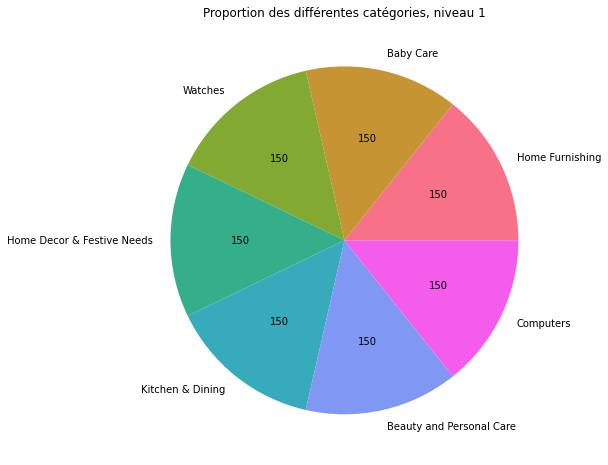

In [47]:
# Pieplot de la répartition des catégories du niveau 1
sns.color_palette("pastel")
df = data.categorie_l1_.value_counts()

fig = plt.figure(1, figsize=(15, 8))
plt.title("Proportion des différentes catégories, niveau 1")
plt.pie(df, labels=list(df.index), autopct='150')
plt.show()

In [48]:
data['categorie_l1_'] = data['categorie_l1_'].astype('category')

In [49]:
list(data['categorie_l1_'].cat.categories)

['Baby Care',
 'Beauty and Personal Care',
 'Computers',
 'Home Decor & Festive Needs',
 'Home Furnishing',
 'Kitchen & Dining',
 'Watches']

In [50]:
# Return Series of codes as well as the index.
data["categorie_n1_"] = data['categorie_l1_'].cat.codes

In [51]:
data.categorie_l1_.value_counts()

Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150
Name: categorie_l1_, dtype: int64

In [52]:
data.categorie_n1_.value_counts()

4    150
0    150
6    150
3    150
5    150
1    150
2    150
Name: categorie_n1_, dtype: int64

In [53]:
data.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,categorie_l1_,categorie_l2_,categorie_n1_
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories,4
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin,0


In [18]:
# data.to_csv('./data/Traited/data_categories.csv', index=False)
data_categories = pd.read_csv('./data/Traited/data_categories.csv')

## Traitement du nom et description du produit

In [3]:
data = data_categories.loc[:, ['uniq_id', 'product_name', 'description',
                           'categorie_l1_', 'categorie_n1_']]

In [4]:
# 'name_description_' est une variable qui contient le nom
# et la description du produit concaténés
data['name_description_'] = data.product_name \
                            + ' ' + data.description

In [5]:
data.head(2)

,uniq_id,product_name,description,categorie_l1_,categorie_n1_,name_description_
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,4,Elegance Polyester Multicolor Abstract Eyelet ...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,0,Sathiyas Cotton Bath Towel Specifications of S...


In [6]:
print(data.product_name[0])

Elegance Polyester Multicolor Abstract Eyelet Door Curtain


In [64]:
print(data.description[0])

Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you 

In [65]:
print(data.name_description_[0])

Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant 

In [66]:
#data.drop(columns=['product_name', 'description'], inplace=True)

In [7]:
#data.head(2)

In [8]:
for idx, ser in data.iloc[:10].iterrows():
    txt_1 = f"categorie_l1 : {ser['categorie_l1_']} \n"
    print(txt_1 + ser['product_name'] + "\n\n")

categorie_l1 : Home Furnishing 
Elegance Polyester Multicolor Abstract Eyelet Door Curtain


categorie_l1 : Baby Care 
Sathiyas Cotton Bath Towel


categorie_l1 : Baby Care 
Eurospa Cotton Terry Face Towel Set


categorie_l1 : Home Furnishing 
SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet


categorie_l1 : Home Furnishing 
Jaipur Print Cotton Floral King sized Double Bedsheet


categorie_l1 : Watches 
Maserati Time R8851116001 Analog Watch  - For Boys


categorie_l1 : Watches 
Camerii WM64 Elegance Analog Watch  - For Men, Boys


categorie_l1 : Watches 
T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys


categorie_l1 : Watches 
Alfajr WY16B Youth Digital Watch  - For Men, Boys


categorie_l1 : Watches 
TAG Heuer CAU1116.BA0858 Formula 1 Analog Watch  - For Boys, Men




In [9]:
for idx, ser in data.iloc[:10].iterrows():
    txt_1 = f"categorie_l1 : {ser['categorie_l1_']} \n"
    print(txt_1 + ser['description'] + "\n\n")

categorie_l1 : Home Furnishing 
Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters

In [68]:
for idx, ser in data.iloc[:10].iterrows():
    txt_1 = f"categorie_l1 : {ser['categorie_l1_']} \n"
    print(txt_1 + ser['name_description_'] + "\n\n")

categorie_l1 : Home Furnishing 
Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing

In [13]:
# name_description_prep_ls_ est le champ qui contient le nom et la description avec un prétraitement et lem et stem
data['name_description_prep_ls_'] = data.name_description_.apply(
    lambda doc: preprocess_text_lem_stem(doc))

In [14]:
# name_description_prep_ est le champ qui contient le nom et la description prétraité sans lem et stem
data['name_description_prep_'] = data.name_description_.apply(
    lambda doc: preprocess_text(doc))

In [15]:
# name_prep_ls_ est le champ qui contient le nom avec un prétraitement et lem et stem
data['name_prep_ls_'] = data.product_name.apply(
    lambda doc: preprocess_text_lem_stem(doc))

In [16]:
data.head(2)

,uniq_id,product_name,description,categorie_l1_,categorie_n1_,name_description_,name_description_prep_ls_,name_description_prep_,name_prep_ls_
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,4,Elegance Polyester Multicolor Abstract Eyelet ...,eleg polyest multicolor abstract eyelet door c...,elegance polyester multicolor abstract eyelet ...,eleg polyest multicolor abstract eyelet door c...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,0,Sathiyas Cotton Bath Towel Specifications of S...,cotton bath towel cotton bath towel bath towel...,cotton bath towel cotton bath towel bath towel...,cotton bath towel


In [18]:
for idx, ser in data.iloc[:10].iterrows():
    txt_1 = f"categorie_l1 : {ser['categorie_l1_']} \n"
    print(txt_1
          + ser['name_description_']
          + "\n\n"
          + ser['name_description_prep_ls_']
          + "\n\n")

categorie_l1 : Home Furnishing 
Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing

In [17]:
for idx, ser in data.iloc[:10].iterrows():
    txt_1 = f"categorie_l1 : {ser['categorie_l1_']} \n"
    print(txt_1
          + ser['product_name']
          + "\n\n"
          + ser['name_prep_ls_']
          + "\n\n")

categorie_l1 : Home Furnishing 
Elegance Polyester Multicolor Abstract Eyelet Door Curtain

eleg polyest multicolor abstract eyelet door curtain


categorie_l1 : Baby Care 
Sathiyas Cotton Bath Towel

cotton bath towel


categorie_l1 : Baby Care 
Eurospa Cotton Terry Face Towel Set

cotton terri face towel set


categorie_l1 : Home Furnishing 
SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet

royal fashion cotton print king size doubl


categorie_l1 : Home Furnishing 
Jaipur Print Cotton Floral King sized Double Bedsheet

print cotton floral king size doubl


categorie_l1 : Watches 
Maserati Time R8851116001 Analog Watch  - For Boys

time watch


categorie_l1 : Watches 
Camerii WM64 Elegance Analog Watch  - For Men, Boys

eleg watch men


categorie_l1 : Watches 
T STAR UFT-TSW-005-BK-BR Analog Watch  - For Boys

star watch


categorie_l1 : Watches 
Alfajr WY16B Youth Digital Watch  - For Men, Boys

youth digit watch men


categorie_l1 : Watches 
TAG Heuer CAU1116.BA0858 

In [19]:
data['length_'] = data['name_description_'].apply(
    lambda txt: len(txt.split()))
print("max length : ", data['length_'].max())

data['length_trans_'] = data['name_description_prep_ls_'].apply(
    lambda txt: len(txt.split()))
print("max length trans: ", data['length_trans_'].max())

max length :  592
max length trans:  296


In [20]:
data.head(2)

,uniq_id,product_name,description,categorie_l1_,categorie_n1_,name_description_,name_description_prep_ls_,name_description_prep_,name_prep_ls_,length_,length_trans_
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,4,Elegance Polyester Multicolor Abstract Eyelet ...,eleg polyest multicolor abstract eyelet door c...,elegance polyester multicolor abstract eyelet ...,eleg polyest multicolor abstract eyelet door c...,237,133
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,0,Sathiyas Cotton Bath Towel Specifications of S...,cotton bath towel cotton bath towel bath towel...,cotton bath towel cotton bath towel bath towel...,cotton bath towel,78,50


In [3]:
# data.iloc[:,:-2].to_csv('./data/Traited/data_categories_trans.csv', index=False)
data_categories = pd.read_csv('./data/Traited/data_categories_trans.csv')

In [5]:
data = data_categories.copy()
data.name_description_[0]

'Elegance Polyester Multicolor Abstract Eyelet Door Curtain Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant

In [6]:
data.name_description_prep_ls_[0]

'eleg polyest multicolor abstract eyelet door curtain key eleg polyest multicolor abstract eyelet door curtain floral curtain polyest multicolor abstract eyelet door curtain height pack price curtain look curtain made high qualiti polyest fabric eyelet style stitch metal ring room environ romant love curtain ant wrinkl anti shrinkag eleg home bright modernist appeal attent sure steal heart contemporari eyelet valanc slide smoothli draw apart first thing morn welcom bright sun want wish good morn whole world draw close even creat special joyou beauti given sooth bring home eleg curtain softli light room get right amount sunlight eleg polyest multicolor abstract eyelet door curtain height pack gener brand eleg design door type eyelet model name abstract polyest door curtain set model color multicolor length box number content packag pack packag bodi design materi polyest'

In [11]:
preprocess_text_lem_stem(data.name_description_[0])

'eleg polyest multicolor abstract eyelet door curtain key featur eleg polyest multicolor abstract eyelet door curtain floral curtain polyest multicolor abstract eyelet door curtain height pack price curtain enhanc look interior curtain made high qualiti polyest fabric featur eyelet style stitch metal ring make room environ romant love curtain ant wrinkl anti shrinkag eleg appar home bright modernist appeal design surreal attent sure steal heart contemporari eyelet valanc curtain slide smoothli draw apart first thing morn welcom bright sun ray want wish good morn whole world draw close even creat special moment joyou beauti given sooth print bring home eleg curtain softli filter light room get right amount sunlight eleg polyest multicolor abstract eyelet door curtain height pack gener brand eleg design door type eyelet model name abstract polyest door curtain set model color multicolor dimens length box number content sale packag pack sale packag curtain bodi design materi polyest'

## Enregistrement des données prétraitées

In [20]:
data = data_categories.copy()
data.head(2)

,uniq_id,product_name,description,categorie_l1_,categorie_n1_,name_description_,name_description_prep_ls_,name_description_prep_,name_prep_ls_
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,4,Elegance Polyester Multicolor Abstract Eyelet ...,eleg polyest multicolor abstract eyelet door c...,elegance polyester multicolor abstract eyelet ...,eleg polyest multicolor abstract eyelet door c...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,0,Sathiyas Cotton Bath Towel Specifications of S...,cotton bath towel cotton bath towel bath towel...,cotton bath towel cotton bath towel bath towel...,cotton bath towel


In [25]:
data.shape

(1050, 9)

In [21]:
data_ = data_categories.loc[:, ['uniq_id', 'product_name', 'description', 'name_description_' ,'categorie_l1_']]
data_.head(1)

,uniq_id,product_name,description,name_description_,categorie_l1_
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing


# Bag of words - Tf-idf

## Préparation

In [5]:
data = pd.read_csv('./data/Traited/data_categories_trans.csv')
print(data.shape)
data.head(2)

(1050, 9)


,uniq_id,product_name,description,categorie_l1_,categorie_n1_,name_description_,name_description_prep_ls_,name_description_prep_,name_prep_ls_
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,4,Elegance Polyester Multicolor Abstract Eyelet ...,eleg polyest multicolor abstract eyelet door c...,elegance polyester multicolor abstract eyelet ...,eleg polyest multicolor abstract eyelet door c...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,0,Sathiyas Cotton Bath Towel Specifications of S...,sathiya cotton bath towel specif sathiya cotto...,sathiyas cotton bath towel specifications sath...,sathiya cotton bath towel


In [3]:
# création du bag of words (CountVectorizer et Tf-idf)
# words that appear in more than 90% of the documents
# should be removed from the vocabulary.
# words that appear in less than 0.5% of the documents
# should be removed from the vocabulary.
cvect = CountVectorizer(stop_words='english',
                        max_df=0.9,
                        min_df=0.005)
ctf = TfidfVectorizer(stop_words='english',
                      max_df=0.9,
                      min_df=0.005)

feat = 'name_description_prep_ls_'
cv_fit = cvect.fit(data[feat])
ctf_fit = ctf.fit(data[feat])

cv_transform = cvect.transform(data[feat])
ctf_transform = ctf.transform(data[feat])

In [4]:
cv_transform

<1050x735 sparse matrix of type '<class 'numpy.int64'>'
	with 25582 stored elements in Compressed Sparse Row format>

In [22]:
cv_features = cv_transform.todense()
cv_features = pd.DataFrame(cv_features, index=data.uniq_id, columns=cvect.get_feature_names_out())
cv_features.to_csv('./data/Traited/df_cv.csv', index=True)
cv_features
# df_use_ = pd.DataFrame(features_USE, index=data.uniq_id)
# df_use = df_use_.reset_index()
# df_use.to_csv('./data/Traited/df_use.csv', index=False)

,absorb,abstract,accessori,actual,adapt,add,addit,adjust,ador,adorn,...,wireless,woman,wood,wooden,work,world,wrap,ye,year,yellow
uniq_id,,,,,,,,,,,,,,,,,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7b72c92c2f6c40268628ec5f14c6d590,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,2
64d5d4a258243731dc7bbb1eef49ad74,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
d4684dcdc759dd9cdf41504698d737d8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6325b6870c54cd47be6ebfbffa620ec7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958f54f4c46b53c8a0a9b8167d9140bc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fd6cbcc22efb6b761bd564c28928483c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
5912e037d12774bb73a2048f35a00009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
ctf_features = ctf_transform.todense()
ctf_features = pd.DataFrame(ctf_features, index=data.uniq_id, columns=ctf.get_feature_names_out())
ctf_features.to_csv('./data/Traited/df_ctf.csv', index=True)
ctf_features

,absorb,abstract,accessori,actual,adapt,add,addit,adjust,ador,adorn,...,wireless,woman,wood,wooden,work,world,wrap,ye,year,yellow
uniq_id,,,,,,,,,,,,,,,,,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,0.00000,0.212844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.056124,0.0,0.000000,0.00000,0.00000
7b72c92c2f6c40268628ec5f14c6d590,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.067003,0.0,0.0,0.0,0.000000,0.0,0.068464,0.00000,0.17613
64d5d4a258243731dc7bbb1eef49ad74,0.06172,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.039024,0.0,0.0,0.0,0.000000,0.0,0.000000,0.04632,0.00000
d4684dcdc759dd9cdf41504698d737d8,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.041534,0.00000,0.00000
6325b6870c54cd47be6ebfbffa620ec7,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.035795,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958f54f4c46b53c8a0a9b8167d9140bc,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.00000
fd6cbcc22efb6b761bd564c28928483c,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.116343,0.0,0.000000,0.00000,0.00000
5912e037d12774bb73a2048f35a00009,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.00000


In [107]:
cvect.get_feature_names_out()

array(['absorb', 'abstract', 'actual', 'adapt', 'add', 'addit', 'adjust',
       'ador', 'afford', 'age', 'air', 'alarm', 'almond', 'aluminium',
       'amaz', 'android', 'anim', 'anoth', 'anti', 'antiqu', 'appeal',
       'appear', 'appl', 'appli', 'applic', 'area', 'aroma', 'art',
       'artifici', 'artist', 'assur', 'attract', 'audio', 'authent',
       'avail', 'away', 'babi', 'bag', 'base', 'basic', 'bath', 'batteri',
       'beauti', 'bed', 'bedroom', 'best', 'big', 'birthday', 'black',
       'blanket', 'bleach', 'blend', 'blue', 'bodi', 'bottl', 'box',
       'boy', 'brand', 'brass', 'break', 'bright', 'bring', 'broadcast',
       'brown', 'brush', 'buckl', 'buddha', 'bulb', 'busi', 'button',
       'buy', 'cabl', 'canva', 'cap', 'capac', 'card', 'care', 'carri',
       'cartoon', 'case', 'cash', 'casual', 'catchi', 'cell', 'center',
       'ceram', 'charg', 'charger', 'check', 'checker', 'cheer', 'chines',
       'choic', 'clasp', 'classic', 'clay', 'clean', 'clear', 'closur'

In [33]:
cv_features = pd.read_csv('./data/Traited/df_cv.csv')
cv_features.drop(columns=['uniq_id'], inplace=True)
ctf_features = pd.read_csv('./data/Traited/df_ctf.csv')
ctf_features.drop(columns=['uniq_id'], inplace=True)

## Exécution des modèles

In [50]:
y_cat_num = data["categorie_n1_"]
print("CountVectorizer : ")
print("-----------------")
ARI_cv, X_tsne_cv, labels_cv = ARI_fct_bow(cv_features, y_cat_num)
print()
print("Tf-idf : ")
print("--------")
ARI_ctf, X_tsne_ctf, labels_ctf = ARI_fct_bow(ctf_features, y_cat_num)

CountVectorizer : 
-----------------
ARI :  0.4962 time :  11.0

Tf-idf : 
--------
ARI :  0.5183 time :  11.0


## Graphiques

In [54]:
data['categorie_l1_'] = data['categorie_l1_'].astype('category')
l_cat = list(data['categorie_l1_'].cat.categories)

In [14]:
l_cat

['Baby Care',
 'Beauty and Personal Care',
 'Computers',
 'Home Decor & Festive Needs',
 'Home Furnishing',
 'Kitchen & Dining',
 'Watches']

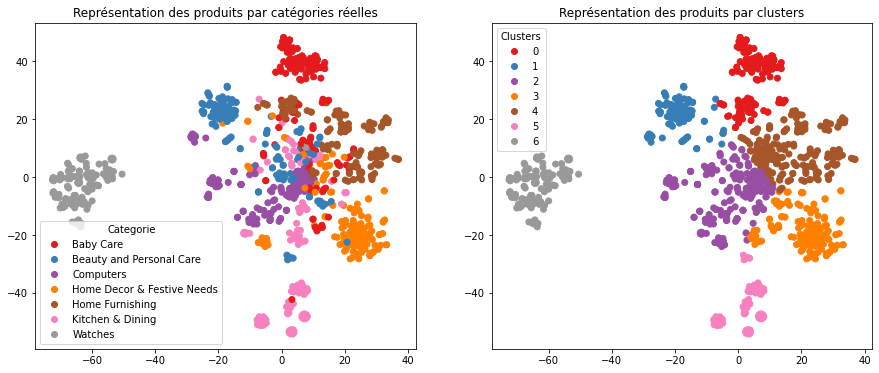

ARI :  0.4962


In [56]:
l_cv = pd.Series(labels_cv).map(
    {0: 6, 1: 4, 2: 1, 3: 5, 4: 3, 5: 0, 6: 2}).values
TSNE_visu_fct(X_tsne_cv, y_cat_num, l_cv, ARI_cv, l_cat)

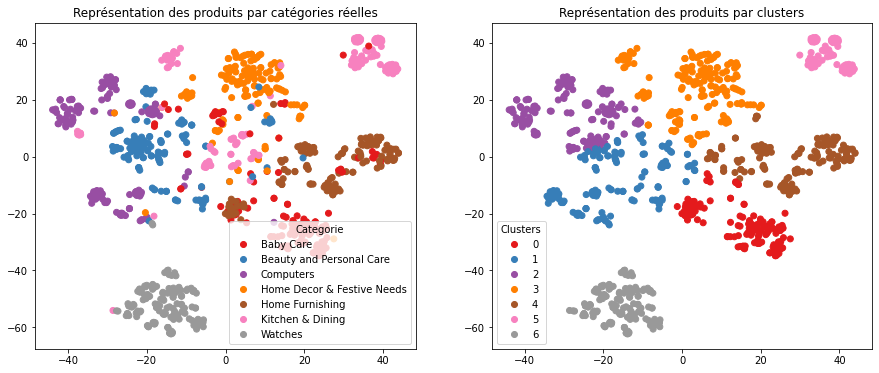

ARI :  0.5183


In [58]:
l_ctf = pd.Series(labels_ctf).map(
    {0: 5, 1: 1, 2: 6, 3: 2, 4: 4, 5: 3, 6: 0}).values
TSNE_visu_fct(X_tsne_ctf, y_cat_num, l_ctf, ARI_ctf, l_cat)

* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les produits selon leurs vraies catégorie. Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les catégories des produits. 
* Il ne s'agit pas de faire une classification non supervisée, mais simplement, par une mesure de l'ARI, de conforter l'analyse graphique précédente qui démontre la faisabilité de réaliser ultérieurement une classification supervisée. Cette mesure de l'ARI nécessite de créer des clusters théoriques via KMeans. 
* Il s'agit donc de réaliser une mesure de ce que nous voyons graphiquement, donc à partir des données en sortie du t-sne
* Pour réaliser une classification non supervisée, il aurait fallu repartir des données avant t-sne
* Dans la démarche en 2 étapes, il n'est pas utile de réaliser une classification non supervisée, une classification supervisée est bien plus performante. Même le calcul de l'ARI n'est pas indispensable, nous pourrions passer directement du graphique t-sne précédent à l'étape 2 de classification supervisée
* Il n'est donc pas utile de passer du temps à optimiser l'ARI, un ordre de grandeur suffit pour conforter le 1er graphique t-sne.

# Word2Vec

In [5]:
data = pd.read_csv('./data/Traited/data_categories_trans.csv')
data.head()

,uniq_id,product_name,description,categorie_l1_,categorie_n1_,name_description_,name_description_prep_ls_,name_description_prep_,name_prep_ls_
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,4,Elegance Polyester Multicolor Abstract Eyelet ...,eleg polyest multicolor abstract eyelet door c...,elegance polyester multicolor abstract eyelet ...,eleg polyest multicolor abstract eyelet door c...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,0,Sathiyas Cotton Bath Towel Specifications of S...,sathiya cotton bath towel specif sathiya cotto...,sathiyas cotton bath towel specifications sath...,sathiya cotton bath towel
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,0,Eurospa Cotton Terry Face Towel Set Key Featur...,eurospa cotton terri face towel set key featur...,eurospa cotton terry face towel set key featur...,eurospa cotton terri face towel set
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,4,SANTOSH ROYAL FASHION Cotton Printed King size...,santosh royal fashion cotton print king size d...,santosh royal fashion cotton printed king size...,santosh royal fashion cotton print king size d...
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,4,Jaipur Print Cotton Floral King sized Double B...,jaipur print cotton floral king size doubl bed...,jaipur print cotton floral king sized double b...,jaipur print cotton floral king size doubl bed...


In [6]:
y_cat_num = data["categorie_n1_"]

In [7]:
data['categorie_l1_'] = data['categorie_l1_'].astype('category')
l_cat = list(data['categorie_l1_'].cat.categories)

## Création du modèle Word2Vec

Tout d'abord, un objet Word2Vec est créé en utilisant les hyperparamètres min_count, window, vector_size, seed et workers.
* **min_count** est le nombre minimum de fois qu'un mot doit apparaître dans le corpus pour être pris en compte dans le modèle.
* **window** est la taille de la fenêtre de contexte autour de chaque mot.
* **vector_size** est la dimensionnalité de l'espace vectoriel dans lequel les mots sont représentés.
* **seed** est une valeur utilisée pour initialiser les poids du modèle, garantissant ainsi que le modèle sera initialisé de la même manière à chaque fois qu'il est exécuté.
* **workers** est le nombre de threads utilisés pour l'entraînement du modèle.

Ensuite, le vocabulaire est construit en utilisant la méthode **build_vocab**, qui prend en entrée une liste de phrases (ou de tokens).

Le modèle est ensuite entraîné en utilisant la méthode train, qui prend en entrée les mêmes phrases et les hyperparamètres total_examples et epochs.
* **total_examples** est le nombre total de phrases dans le corpus.
* **epochs** est le nombre de fois que le modèle parcourt tout le corpus lors de l'entraînement.

Enfin, les vecteurs de mots du modèle sont extraits en utilisant l'attribut wv, et les mots correspondant à ces vecteurs sont extraits en utilisant l'attribut index_to_key. La taille du vocabulaire est également imprimée à la fin de l'exécution du code.

In [81]:
w2v_size = 300  # Dimensionality of the feature vectors. - (50, 300)
w2v_window = 15  # The maximum distance between the current and predicted word within a sentence.
w2v_min_count = 5  # Ignores all words with total absolute frequency lower than this - (2, 100)
w2v_epochs = 30  # Number of iterations (epochs) over the corpus - [10, 20, 30]
maxlen = None  # adapt to length of sentences
sentences =  data['name_description_prep_'].to_list() # data['name_description_prep_ls_'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [82]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count,
                                   window=w2v_window,
                                   vector_size=w2v_size,
                                   seed=42,
                                   workers=1)
#                                  workers=multiprocessing.cpu_count())

w2v_model.build_vocab(sentences)

w2v_model.train(sentences,
                total_examples=w2v_model.corpus_count,
                epochs=w2v_epochs)

model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 1645
Word2Vec trained


Tout d'abord, un objet Tokenizer est créé en utilisant la bibliothèque Keras.

La méthode **fit_on_texts** est utilisée pour ajuster le tokenizer aux phrases d'entraînement. Cela permet au tokenizer de construire un dictionnaire de tous les mots dans les phrases d'entraînement, ainsi que de leur fréquence d'apparition.

Ensuite, les phrases sont converties en séquences de nombres entiers en utilisant la méthode **texts_to_sequences** du tokenizer. Cela remplace chaque mot dans la phrase par son index dans le dictionnaire construit à l'étape précédente.

Les séquences de nombres entiers sont ensuite remplies avec des zéros ou tronquées pour avoir la même longueur en utilisant la fonction **pad_sequences** de Keras. Cela permet d'avoir des entrées de taille fixe pour l'entraînement du modèle.

La variable num_words est ensuite définie comme étant le nombre total de mots uniques dans le dictionnaire, en ajoutant 1 pour inclure un token réservé pour les mots inconnus.

Enfin, la taille du vocabulaire est imprimée à la fin de l'exécution du code.

In [83]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                            maxlen=maxlen,
                            padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4713


## Création de la matrice d'embedding

Pour chaque mot dans le dictionnaire, une recherche est effectuée pour voir si l'embedding pour ce mot existe dans le modèle Word2Vec entraîné précédemment. Si oui, l'embedding correspondant est ajouté à la matrice d'embedding à la position de l'index du mot dans le dictionnaire.

Enfin, la proportion de mots dans le vocabulaire qui ont un embedding est calculée et affichée, ainsi que la forme de la matrice d'embedding.

In [84]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  0.3491
Embedding matrix: (4713, 300)


## Création du modèle d'embedding

Tout d'abord, une couche d'entrée est créée avec une forme correspondant à la forme de x_sentences.

Ensuite, une autre couche d'entrée est créée pour les mots individuels dans chaque phrase, avec une forme correspondant à la longueur maximale de chaque phrase (maxlen).

Une couche d'embedding est créée en utilisant les poids de la matrice d'embedding créée précédemment, avec l'input_dim défini comme la taille du vocabulaire, output_dim défini comme la taille de l'embedding (w2v_size), et input_length défini comme la longueur maximale de chaque phrase (maxlen).

Une couche de Global Average Pooling est ajoutée pour calculer la moyenne des embeddings des mots dans chaque phrase.

Un modèle d'embedding est créé en utilisant les entrées pour les mots individuels et la sortie de la couche de Global Average Pooling.

Enfin, un résumé du modèle est affiché.

Le modèle d'embedding ainsi créé peut être utilisé comme base pour construire un modèle de classification ou de régression en ajoutant d'autres couches de neurones après la couche de Global Average Pooling.

In [85]:
# Création du modèle
input=Input(shape=(len(x_sentences),maxlen),dtype='float64')

word_input=Input(shape=(maxlen,),dtype='float64')  

word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_9 (Embedding)     (None, None, 300)         1413900   
                                                                 
 global_average_pooling1d_9   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 1,413,900
Trainable params: 1,413,900
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle

In [86]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 9ms/step


(1050, 300)

In [89]:
w2v_features = pd.DataFrame(embeddings, index=data.uniq_id)
w2v_features.to_csv('./data/Traited/df_w2v.csv', index=True)
w2v_features

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
uniq_id,,,,,,,,,,,,,,,,,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,-0.042940,-0.109213,-0.040596,0.129268,0.057174,0.041914,0.149390,-0.036231,0.138934,-0.055482,...,0.089768,0.027849,-0.128270,-0.008449,-0.240745,0.102743,0.047856,0.026096,0.100513,0.054185
7b72c92c2f6c40268628ec5f14c6d590,-0.077359,-0.018202,-0.011391,0.008709,0.070868,0.074994,-0.002351,0.002521,0.114646,0.082744,...,0.052222,-0.039949,0.089398,-0.106767,-0.044543,-0.046889,-0.050720,0.071221,0.048291,0.113280
64d5d4a258243731dc7bbb1eef49ad74,-0.143243,-0.095129,0.034800,-0.000408,0.037582,0.110665,-0.023122,0.044198,0.137404,0.214732,...,0.125498,-0.060330,0.098538,-0.154971,-0.060832,-0.011481,0.016176,0.108090,-0.033356,0.079517
d4684dcdc759dd9cdf41504698d737d8,-0.087270,-0.088876,-0.035222,-0.102157,-0.089858,0.049246,0.004754,-0.123012,0.158620,0.178459,...,0.178246,-0.083299,0.105791,-0.156970,-0.107924,0.047559,0.125570,0.070303,-0.107624,-0.003793
6325b6870c54cd47be6ebfbffa620ec7,-0.087343,-0.131423,-0.038569,-0.084205,-0.163376,0.024990,-0.007063,-0.141668,0.226699,0.240156,...,0.243696,-0.067110,-0.004122,-0.142977,-0.124353,0.110698,0.176122,0.117287,-0.173825,0.005834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958f54f4c46b53c8a0a9b8167d9140bc,0.065494,-0.154791,0.121665,0.036530,-0.264483,0.002672,-0.004866,0.183423,0.053833,0.100051,...,-0.109144,0.129909,-0.134173,0.083875,-0.016791,0.026952,-0.032433,0.084611,0.036307,-0.042123
fd6cbcc22efb6b761bd564c28928483c,-0.024080,-0.216430,0.045556,0.083958,-0.214852,0.033152,0.039005,0.175472,0.034195,0.092514,...,-0.036574,0.059522,-0.156299,0.024287,-0.063079,0.070982,0.048185,-0.004403,-0.024968,-0.057416
5912e037d12774bb73a2048f35a00009,-0.012765,-0.001656,-0.006029,0.003393,-0.022244,0.012161,0.014599,-0.006490,-0.023071,0.009202,...,-0.008072,0.056562,0.038926,-0.035332,0.018186,-0.014635,0.038906,0.001043,-0.036026,0.001701


In [90]:
w2v_features = pd.read_csv('./data/Traited/df_w2v.csv')
w2v_features.drop(columns=['uniq_id'], inplace=True)

In [92]:
ARI_w2v, X_tsne_w2v, labels_w2v = ARI_fct(w2v_features, y_cat_num)

Dimensions dataset avant réduction PCA :  (1050, 300)
Dimensions dataset après réduction PCA :  (1050, 28)
ARI :  0.4227 time :  14.0


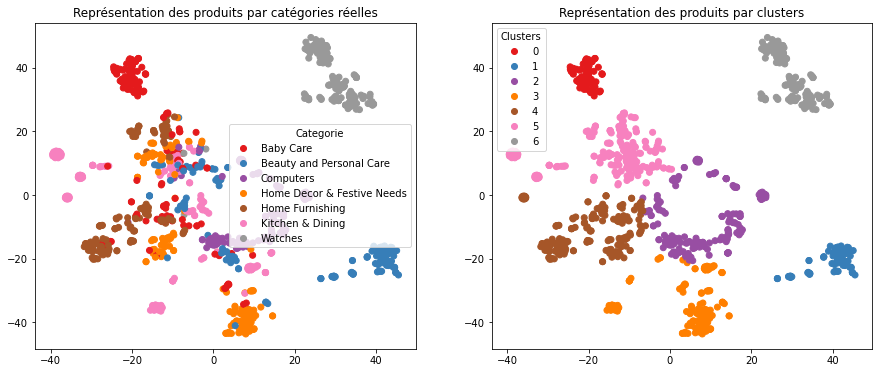

ARI :  0.4227


In [94]:
l_w2v = pd.Series(labels_w2v).map(
    {0: 0, 1: 3, 2: 6, 3: 2, 4: 5, 5: 4, 6: 1}).values
TSNE_visu_fct(X_tsne_w2v, y_cat_num, l_w2v, ARI_w2v, l_cat)

# BERT

In [25]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))
print(tf.test.is_built_with_cuda())

2.11.0
2.11.0
Num CPUs Available:  1
False


In [30]:
data = pd.read_csv('./data/Traited/data_categories_trans.csv')
data.head(2)

,uniq_id,product_name,description,categorie_l1_,categorie_n1_,name_description_,name_description_prep_ls_,name_description_prep_,name_prep_ls_
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,4,Elegance Polyester Multicolor Abstract Eyelet ...,eleg polyest multicolor abstract eyelet door c...,elegance polyester multicolor abstract eyelet ...,eleg polyest multicolor abstract eyelet door c...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,0,Sathiyas Cotton Bath Towel Specifications of S...,cotton bath towel cotton bath towel bath towel...,cotton bath towel cotton bath towel bath towel...,cotton bath towel


In [38]:
y_cat_num = data["categorie_n1_"]

In [39]:
data['categorie_l1_'] = data['categorie_l1_'].astype('category')
l_cat = list(data['categorie_l1_'].cat.categories)

## BERT HuggingFace: 'bert-base-uncased'

* **max_length** : il s'agit de la longueur maximale (en nombre de tokens) des séquences de texte qui seront utilisées comme entrée pour le modèle. Si une séquence est plus longue que max_length, elle sera tronquée, et si elle est plus courte, elle sera remplie avec des tokens spéciaux (généralement des zéros). max_length est définie à 296 qui correspond à la plus longue phrase dans notre corpus.
* **batch_size** : il s'agit du nombre d'exemples d'entraînement qui sont traités en même temps par le modèle lors de l'entraînement. Dans cet exemple, batch_size est défini à 10.
* **model_type** : il s'agit du type de modèle pré-entraîné qui sera utilisé pour l'entraînement. Dans notre cas, le modèle BERT pré-entraîné est utilisé, avec la configuration bert-base-uncased. Il s'agit d'une version de BERT qui utilise un vocabulaire de 30 000 mots, avec des lettres en minuscule et sans accentuation.
Ensuite, la variable sentences est définie en récupérant les données pré-traitées de la colonne name_description_prep_ls_ de l'objet data.

In [38]:
max_length = 50
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data['product_name'].to_list()

loading configuration file config.json from cache at C:\Users\rimla/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at C:\Users\rimla/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb42

* **mode** : il s'agit du mode d'extraction de features. Dans ce cas, il est défini à 'HF', ce qui signifie que la fonction utilise l'interface Hugging Face de TensorFlow pour extraire les features.
La fonction feature_BERT_fct doit renvoyer deux valeurs :
* **features_bert** : il s'agit d'un tableau numpy qui contient les features BERT extraits pour chaque séquence de texte dans sentences.
* **last_hidden_states_tot** : il s'agit d'un tableau numpy qui contient les états cachés de la dernière couche du modèle BERT pour chaque séquence de texte dans sentences. Ces états cachés peuvent être utilisés pour d'autres tâches, telles que la classification de texte ou la génération de texte.

In [41]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

loading configuration file config.json from cache at C:\Users\rimla/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\rimla/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\vocab.t

1/1 [==============================] - 1s 656ms/step
temps traitement :  90.0


In [44]:
beart_hf_features = pd.DataFrame(features_bert, index=data.uniq_id)
beart_hf_features.to_csv('./data/Traited/df_beat_hf.csv', index=True)
beart_hf_features

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
uniq_id,,,,,,,,,,,,,,,,,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,-0.058413,-0.267061,0.189823,0.036560,0.598398,0.248052,-0.034403,-0.098131,-0.143196,-0.305524,...,0.343682,-0.443662,0.349961,0.082443,0.151359,-0.111228,0.307006,-0.069748,-0.098255,-0.003738
7b72c92c2f6c40268628ec5f14c6d590,0.223798,-0.099305,-0.015371,0.247978,0.105310,0.152894,0.135469,0.007955,-0.173383,-0.349832,...,-0.126165,-0.027812,0.109360,0.266649,-0.079074,0.177866,-0.175618,-0.217722,0.018634,-0.168225
64d5d4a258243731dc7bbb1eef49ad74,0.187310,-0.321013,0.034524,0.249724,0.136209,0.022940,-0.135344,-0.061348,-0.064238,-0.105343,...,0.076195,-0.200690,0.045066,0.032226,0.099418,0.122223,0.088406,-0.027132,-0.199557,-0.043938
d4684dcdc759dd9cdf41504698d737d8,0.242149,-0.303718,0.446249,0.099264,0.469534,-0.106954,-0.124224,0.288683,-0.148019,-0.188483,...,0.112104,-0.142406,0.271270,-0.075795,0.261506,0.123035,-0.066197,-0.008949,0.259409,-0.348187
6325b6870c54cd47be6ebfbffa620ec7,0.164508,-0.314754,0.271180,0.068370,0.497277,-0.012259,-0.118507,0.325545,-0.088443,-0.354753,...,0.209127,-0.088005,0.288363,0.015075,0.176778,0.072326,-0.189191,0.042002,0.264080,-0.399062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958f54f4c46b53c8a0a9b8167d9140bc,0.061704,-0.172816,0.335329,0.211080,-0.210744,-0.005454,-0.137729,-0.259079,0.104022,-0.279632,...,0.130921,-0.293183,0.351952,0.043123,0.299495,-0.053284,-0.150821,-0.074647,-0.228046,-0.073218
fd6cbcc22efb6b761bd564c28928483c,0.271590,-0.102652,-0.053117,0.307246,0.090519,0.117712,-0.068329,0.056143,0.077903,-0.061677,...,0.127073,-0.283838,0.136840,0.010133,0.251094,-0.072794,-0.033907,0.125974,0.113015,-0.306911
5912e037d12774bb73a2048f35a00009,0.299858,-0.156428,0.300482,0.201215,0.060898,-0.019820,-0.339382,0.007418,-0.006894,-0.020644,...,0.072188,-0.281328,-0.053568,-0.030795,0.116518,-0.047306,-0.224344,0.086648,-0.148809,-0.017197


In [26]:
beart_hf_features = pd.read_csv('./data/Traited/df_beat_hf.csv')
beart_hf_features.drop(columns=['uniq_id'], inplace=True)

In [27]:
ARI_bert, X_tsne_bert, labels_bert = ARI_fct(beart_hf_features, y_cat_num)

Dimensions dataset avant réduction PCA :  (1050, 768)
Dimensions dataset après réduction PCA :  (1050, 387)
ARI :  0.63 time :  10.0


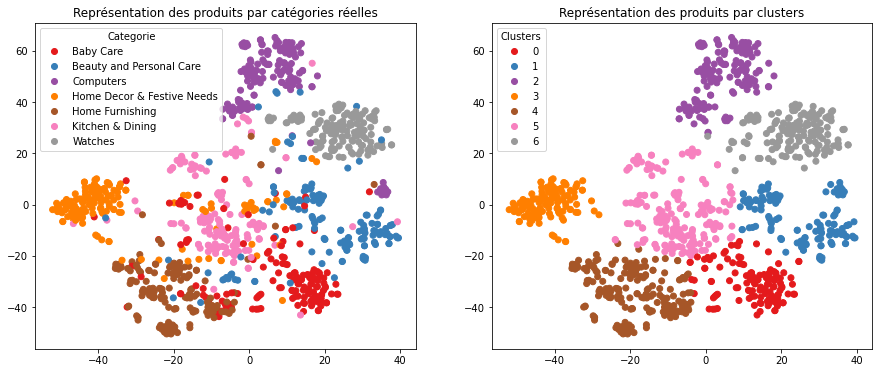

ARI :  0.63


In [67]:
# TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

l_bert = pd.Series(labels_bert).map(
    {0: 5, 1: 6, 2: 2, 3: 0, 4: 4, 5: 3, 6: 1}).values
TSNE_visu_fct(X_tsne_bert, y_cat_num, l_bert, ARI_bert, l_cat)

## BERT hub Tensorflow

Une couche de prétraitement BERT est chargée depuis Tensorflow Hub à partir de l'URL model_url. Cette couche est ensuite utilisée pour créer un modèle de classification de texte.

La couche de prétraitement BERT permet de transformer les phrases en une représentation vectorielle dense qui peut être utilisée en entrée d'un modèle de classification ou d'un modèle de régression. Cette couche a été entraînée sur une grande quantité de données textuelles et est capable de capturer les nuances sémantiques et syntaxiques des phrases. Le paramètre trainable=True signifie que les poids de la couche BERT peuvent être ajustés pendant l'apprentissage du modèle.

In [49]:
import tensorflow_hub as hub
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [50]:
sentences = data['product_name'].to_list()

In [51]:
max_length = 20
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

loading configuration file config.json from cache at C:\Users\rimla/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\rimla/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\vocab.t

temps traitement :  46.0


In [52]:
beart_ht_features = pd.DataFrame(features_bert, index=data.uniq_id)
beart_ht_features.to_csv('./data/Traited/df_beat_ht.csv', index=True)
beart_ht_features

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
uniq_id,,,,,,,,,,,,,,,,,,,,,
55b85ea15a1536d46b7190ad6fff8ce7,0.033741,-0.265727,0.256611,-0.018957,0.715190,0.221103,-0.119139,-0.071558,-0.156360,-0.329636,...,0.345465,-0.431497,0.408985,0.003417,0.192981,-0.064741,0.272768,0.011360,-0.117053,0.003129
7b72c92c2f6c40268628ec5f14c6d590,0.333538,-0.098647,-0.066825,0.207597,0.102506,0.067004,0.193315,0.083166,-0.213509,-0.286459,...,-0.149355,0.029488,0.081397,0.243895,-0.086235,0.235895,-0.172642,-0.263945,-0.044628,-0.172939
64d5d4a258243731dc7bbb1eef49ad74,0.299730,-0.276037,0.086842,0.184788,0.137139,0.016450,-0.135248,-0.041064,-0.131114,-0.067760,...,0.057902,-0.172555,0.034283,0.006859,0.172920,0.158465,0.033027,-0.034286,-0.255232,-0.033185
d4684dcdc759dd9cdf41504698d737d8,0.357146,-0.313191,0.404313,0.002648,0.568520,-0.324743,-0.192859,0.404563,-0.220386,-0.155531,...,0.110465,-0.040481,0.276768,-0.155397,0.226962,0.178381,-0.113454,-0.106841,0.287815,-0.499692
6325b6870c54cd47be6ebfbffa620ec7,0.328394,-0.287149,0.264323,0.033349,0.602337,-0.197578,-0.191571,0.351762,-0.133851,-0.280964,...,0.185916,0.002916,0.315465,-0.055664,0.203016,0.103386,-0.226612,-0.078285,0.260338,-0.507376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958f54f4c46b53c8a0a9b8167d9140bc,0.090269,-0.207505,0.334414,0.143007,-0.181038,-0.158031,-0.113760,-0.192414,0.065514,-0.289791,...,0.173108,-0.371361,0.336703,0.041209,0.373914,0.016955,-0.140641,-0.139848,-0.285729,-0.173446
fd6cbcc22efb6b761bd564c28928483c,0.277459,-0.059656,0.063581,0.275945,0.162542,0.016318,-0.092847,0.012503,0.070440,-0.106697,...,0.115115,-0.310008,0.159246,-0.059432,0.264151,-0.089341,-0.071027,0.149960,0.013256,-0.359901
5912e037d12774bb73a2048f35a00009,0.415244,-0.084950,0.324581,0.200362,0.200083,-0.107836,-0.387468,0.077580,-0.064060,0.104776,...,0.011240,-0.308885,-0.151234,-0.016090,0.228547,0.008003,-0.214451,0.122286,-0.162395,-0.024161


In [95]:
beart_ht_features = pd.read_csv('./data/Traited/df_beat_ht.csv')
beart_ht_features.drop(columns=['uniq_id'], inplace=True)

In [96]:
ARI_Bhub, X_tsne_Bhub, labels_Bhub = ARI_fct(beart_ht_features,  y_cat_num)

Dimensions dataset avant réduction PCA :  (1050, 768)
Dimensions dataset après réduction PCA :  (1050, 402)
ARI :  0.6139 time :  11.0


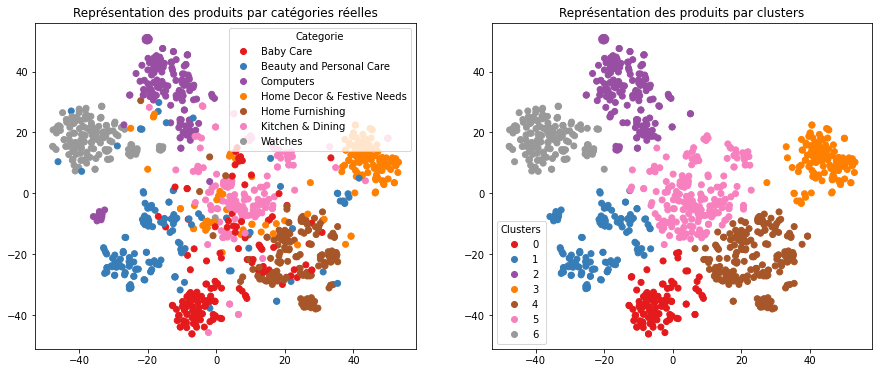

ARI :  0.6139


In [98]:
l_Bhub = pd.Series(labels_Bhub).map(
    {0: 1, 1: 3, 2: 6, 3: 4, 4: 5, 5: 0, 6: 2}).values
TSNE_visu_fct(X_tsne_Bhub, y_cat_num, l_Bhub, ARI_Bhub, l_cat)

# USE - Universal Sentence Encoder

In [3]:
data = pd.read_csv('./data/Traited/data_categories_trans.csv')
data.head(2)

,uniq_id,product_name,description,categorie_l1_,categorie_n1_,name_description_,name_description_prep_ls_,name_description_prep_,name_prep_ls_
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,4,Elegance Polyester Multicolor Abstract Eyelet ...,eleg polyest multicolor abstract eyelet door c...,elegance polyester multicolor abstract eyelet ...,eleg polyest multicolor abstract eyelet door c...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,0,Sathiyas Cotton Bath Towel Specifications of S...,cotton bath towel cotton bath towel bath towel...,cotton bath towel cotton bath towel bath towel...,cotton bath towel


In [4]:
y_cat_num = data["categorie_n1_"]
data['categorie_l1_'] = data['categorie_l1_'].astype('category')
l_cat = list(data['categorie_l1_'].cat.categories)

## Création du modèle 

In [56]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [57]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

## Exécution du modèle

In [58]:
batch_size = 10
sentences = data['product_name'].to_list()

In [59]:
features_USE = feature_USE_fct(sentences, batch_size)

In [60]:
features_USE.shape

(1050, 512)

In [61]:
# enregistrement des features textuelles
df_use_ = pd.DataFrame(features_USE, index=data.uniq_id)
df_use = df_use_.reset_index()
df_use.to_csv('./data/Traited/df_use.csv', index=False)

In [18]:
df_use.head(2)

,uniq_id,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,55b85ea15a1536d46b7190ad6fff8ce7,0.056465,-0.016699,-0.037086,0.043791,0.002945,0.067963,-0.016188,0.046416,0.033914,...,-0.057716,-0.015940,-0.017477,0.069993,0.053311,-0.006422,0.019230,-0.013060,0.049839,0.063842
1,7b72c92c2f6c40268628ec5f14c6d590,0.005994,0.054335,-0.008692,0.028411,0.077500,0.083581,0.034467,-0.015866,-0.013572,...,0.064480,-0.043876,-0.055092,-0.053607,-0.018392,-0.045410,-0.046664,-0.002589,0.068149,0.025688


In [68]:
features_USE = pd.read_csv('./data/Traited/df_use.csv')
features_USE.drop(columns=['uniq_id'], inplace=True)

In [69]:
ARI_USE, X_tsne_USE, labels_USE = ARI_fct(features_USE,  y_cat_num)

Dimensions dataset avant réduction PCA :  (1050, 512)
Dimensions dataset après réduction PCA :  (1050, 303)
ARI :  0.6894 time :  10.0


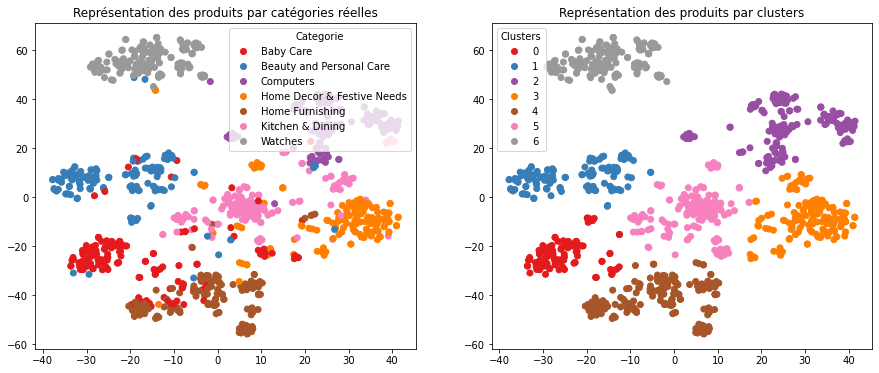

ARI :  0.6894


In [71]:
l_USE = pd.Series(labels_USE).map(
    {0: 3, 1: 1, 2: 6, 3: 4, 4: 2, 5: 0, 6: 5}).values
TSNE_visu_fct(X_tsne_USE, y_cat_num, l_USE, ARI_USE, l_cat)

# Conclusion

**Etude de faisabilité via les données textuelles:**  
**L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les produits selon leurs vraies catégorie.** Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les catégories des produits.  
**Plusieurs approches ont été testées, les meilleurs résultats sont obtenus par le modèle USE sur les noms des produits. On obtient un ARI de 0.7**.

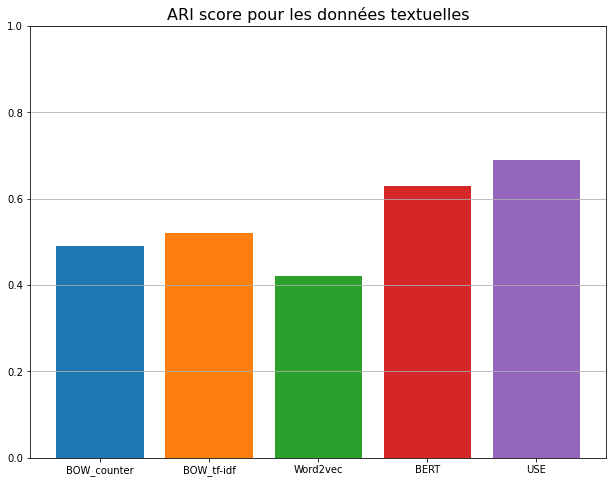

In [99]:
import matplotlib.pyplot as plt

fig = plt.figure( figsize=(8, 6))
ax = fig.add_axes([0,0,1,1])

ari_ = [0.49, 0.52, 0.42, 0.63, 0.69]
model_ = ['BOW_counter', 'BOW_tf-idf', 'Word2vec', 'BERT', 'USE']

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'] # Specify colors for the bars

ax.bar(model_, ari_, color=colors)# Use the colors for the bars
ax.set_ylim(0, 1)
ax.grid(axis='y')
ax.set_title('ARI score pour les données textuelles', fontsize=16)
plt.show()



ax.bar(model_, ari_, color=colors) # Use the colors for the bars
ax.set_ylim(0, 1)
ax.grid(axis='y')
ax.set_title('ARI score pour les données textuelles', fontsize=16) # Increase font size for the title
ax.set_xlabel('Modèles', fontsize=14) # Increase font size for the x-axis label
ax.set_ylabel('Score ARI', fontsize=14) # Increase font size for the y-axis label
ax.tick_params(axis='both', labelsize=12) # Increase font size for the tick labels on both axes

plt.show()